In [1]:
import pandas as pd
import numpy as np
from keras.layers import Dense, Input, Dropout
from keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import RandomForestRegressor
from keras.optimizers import Adam
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mlmicrophysics.explain import partial_dependence_1d
%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv("/Users/dgagne/data/cabauw_derived_data_20190312.csv", index_col="Time", parse_dates=["Time"])
data = data.dropna()

In [118]:
corr_matrix = data.loc[:].corr()

([<matplotlib.axis.YTick at 0x12b8363c8>,
 <a list of 68 Text yticklabel objects>)

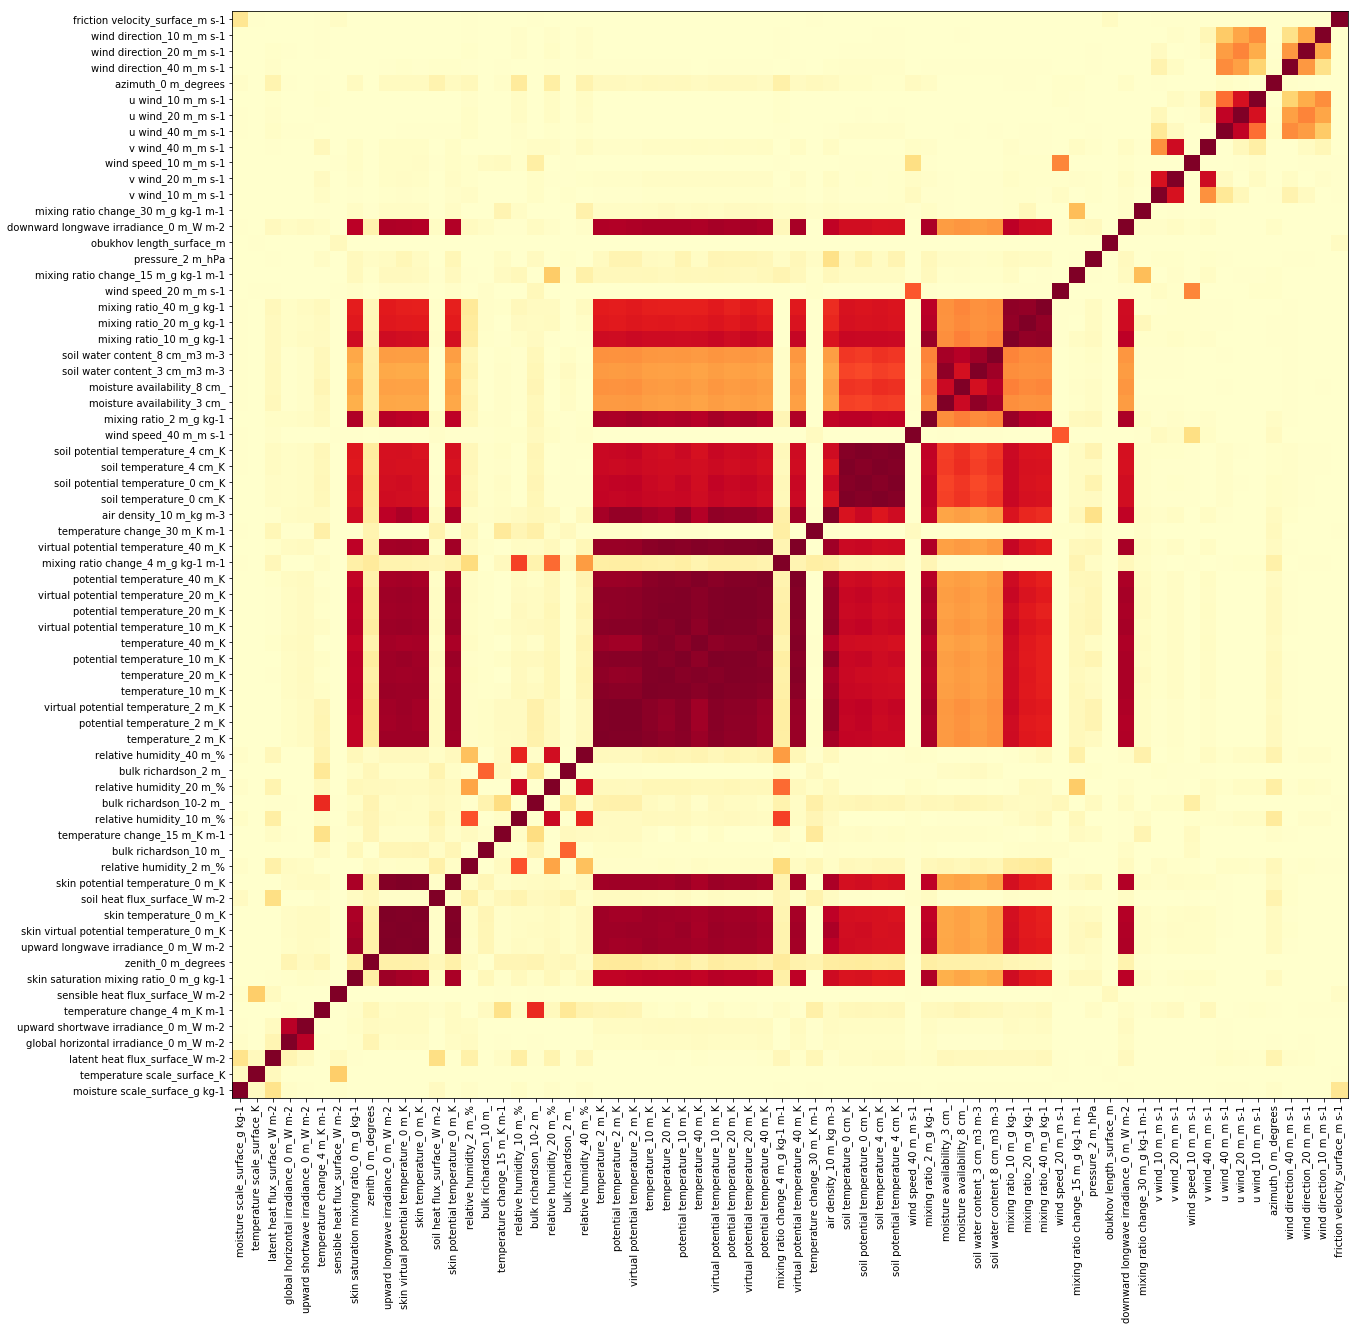

In [115]:
plt.figure(figsize=(20, 20))
plt.pcolormesh(corr_matrix.loc[most_corr.index, most_corr.index] ** 2, vmin=0, vmax=1, cmap="YlOrRd")
plt.xticks(np.arange(0.5,corr_matrix.shape[0]+0.5), most_corr.index, rotation=90)
plt.yticks(np.arange(0.5,corr_matrix.shape[0]+0.5), most_corr.index)

In [121]:
most_corr = (corr_matrix["moisture scale_surface_g kg-1"] **2).sort_values()[::-1]
for index, v in enumerate(most_corr):
    print(f"{most_corr.index[index]:50s} {v:0.3f}")

moisture scale_surface_g kg-1                      1.000
latent heat flux_surface_W m-2                     0.477
temperature change_4 m_K m-1                       0.430
global horizontal irradiance_0 m_W m-2             0.410
upward shortwave irradiance_0 m_W m-2              0.396
temperature scale_surface_K                        0.362
bulk richardson_10 m_                              0.297
temperature change_15 m_K m-1                      0.286
skin saturation mixing ratio_0 m_g kg-1            0.280
zenith_0 m_degrees                                 0.279
upward longwave irradiance_0 m_W m-2               0.255
skin virtual potential temperature_0 m_K           0.251
skin temperature_0 m_K                             0.246
soil heat flux_surface_W m-2                       0.244
skin potential temperature_0 m_K                   0.243
bulk richardson_10-2 m_                            0.239
sensible heat flux_surface_W m-2                   0.213
temperature change_30 m_K m-1  

In [17]:
np.corrcoef(data["skin temperature_0 m_K"], data["moisture scale_surface_g kg-1"])

array([[1.        , 0.49596005],
       [0.49596005, 1.        ]])

(array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([-0.53542949, -0.46908611, -0.40274273, -0.33639935, -0.27005598,
        -0.2037126 , -0.13736922, -0.07102584, -0.00468246,  0.06166091,
         0.12800429,  0.19434767,  0.26069105,  0.32703442,  0.3933778 ,
         0.45972118,  0.52606456,  0.59240794,  0.65875131,  0.72509469,
         0.79143807,  0.85778145,  0.92412483,  0.9904682 ,  1.05681158,
         1.12315496,  1.18949834,  1.25584171,  1.32218509,  1.38852847,
         1.45487185,  1.52121523,  1.5875586 ,  1.65390198,  1.72024536,
         1.78658874,  1.85293212,  1.91927549,  1.98561887,  2.05196225,
         2.11830563,  2.184649  ,  2.25099238,  2.31733576,  2.38367914,
         2.45002252,  2.51636589,  2.58270927,  2.64905265

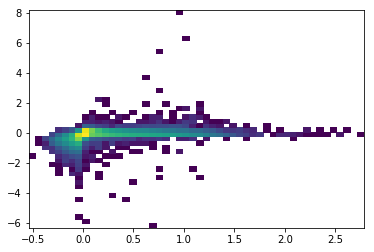

In [80]:
plt.hist2d(data["bulk richardson_10-2 m_"], data["temperature scale_surface_K"], cmin=1, bins=50,norm=LogNorm())

In [59]:
scaled_skin_temperature = (data["skin temperature_0 m_K"] - data["skin temperature_0 m_K"].mean()) / data["skin temperature_0 m_K"].std()
rescaled_skin_temperature = scaled_skin_temperature * data["temperature_2 m_K"].std() + data["temperature_2 m_K"].mean()

(array([8.0000e+00, 6.0000e+00, 3.0000e+00, 1.1000e+01, 2.3000e+01,
        1.7000e+01, 2.2000e+01, 3.1000e+01, 1.7000e+01, 2.7000e+01,
        2.6000e+01, 7.4000e+01, 1.3000e+02, 3.5300e+02, 7.2000e+02,
        1.5300e+03, 2.8530e+03, 4.8410e+03, 7.3850e+03, 1.1408e+04,
        1.6905e+04, 2.6153e+04, 4.2537e+04, 6.7807e+04, 9.0124e+04,
        9.9758e+04, 8.9898e+04, 6.9423e+04, 4.6509e+04, 2.8981e+04,
        1.7646e+04, 1.0644e+04, 6.4990e+03, 4.2590e+03, 2.8350e+03,
        1.9290e+03, 1.3230e+03, 8.9900e+02, 5.1800e+02, 3.2700e+02,
        1.7500e+02, 1.2500e+02, 8.0000e+01, 5.6000e+01, 2.8000e+01,
        9.0000e+00, 5.0000e+00, 1.0000e+00, 3.0000e+00, 3.0000e+00]),
 array([-13.36312086, -12.84048397, -12.31784709, -11.7952102 ,
        -11.27257332, -10.74993643, -10.22729955,  -9.70466266,
         -9.18202578,  -8.6593889 ,  -8.13675201,  -7.61411513,
         -7.09147824,  -6.56884136,  -6.04620447,  -5.52356759,
         -5.00093071,  -4.47829382,  -3.95565694,  -3.43302005

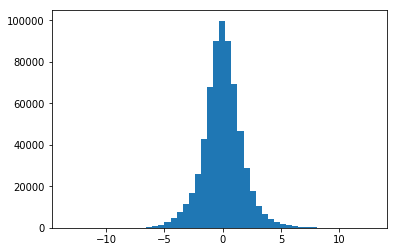

In [57]:
plt.hist(rescaled_skin_temperature - data["temperature_2 m_K"], bins=50)

In [61]:
(rescaled_skin_temperature - data["temperature_2 m_K"]).idxmax()

Timestamp('2006-05-14 11:20:00')

(732445.0, 732448.0)

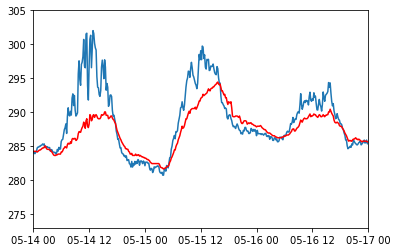

In [64]:

plt.plot(rescaled_skin_temperature)
plt.plot(data["temperature_2 m_K"], color="red", label="2 m")
#plt.plot(data["temperature_10 m_K"], color="orange", label="10 m")
#plt.plot(data["temperature_20 m_K"], color="yellow", label="20 m")
#plt.plot(data["temperature_40 m_K"], color="pink", label="40 m")
#plt.plot(data["soil temperature_0 cm_K"], color="brown")
#plt.plot(data["soil temperature_4 cm_K"], color="green")

plt.ylim(273, 305)
plt.xlim(pd.Timestamp("2006-05-14"), pd.Timestamp("2006-05-17"))

[[1.         0.92006365]
 [0.92006365 1.        ]]


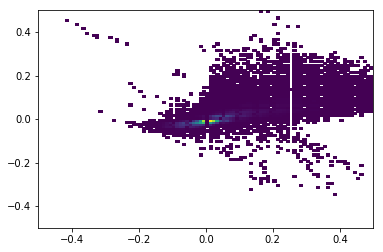

In [11]:
plt.hist2d(data["temperature change_4 m_K m-1"], data["temperature change_15 m_K m-1"],
           cmin=1, bins=np.arange(-0.5, 0.51, 0.01))
#plt.plot(np.arange(250, 310), np.arange(250, 310), 'w--')
print(np.corrcoef(data["skin potential temperature_0 m_K"], data["potential temperature_40 m_K"]))

In [10]:
data["temperature change_15 m_K m-1"].max()

0.5

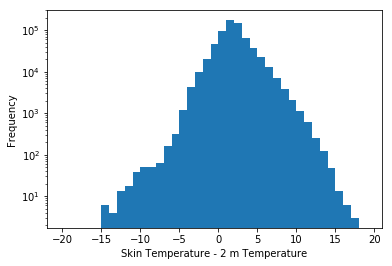

In [28]:
plt.hist(data["skin potential temperature_0 m_K"]- data["potential temperature_2 m_K"], bins=np.arange(-20, 20))
plt.gca().set_yscale("log")
plt.xlabel("Skin Temperature - 2 m Temperature")
plt.ylabel("Frequency")
plt.savefig("skin_temp_diff.png", dpi=150, bbox_inches="tight")

In [4]:
input_cols = ['global horizontal irradiance_0 m_W m-2', 'zenith_0 m_degrees',
              'potential temperature_20 m_K', "potential temperature_10 m_K",
              "potential temperature_2 m_K", 'temperature change_15 m_K m-1', 'temperature change_30 m_K m-1',
              'pressure_2 m_hPa', 'wind speed_20 m_m s-1', 'wind speed_10 m_m s-1', 'bulk richardson_10-2 m_']
output_col = "temperature scale_surface_K"

(array([ 33206.,  69155.,  87495.,  47526.,  36021.,  39200.,  27959.,
         21954.,  25654., 266774.]),
 array([0.17674216, 0.25906795, 0.34139373, 0.42371951, 0.5060453 ,
        0.58837108, 0.67069687, 0.75302265, 0.83534843, 0.91767422,
        1.        ]),
 <a list of 10 Patch objects>)

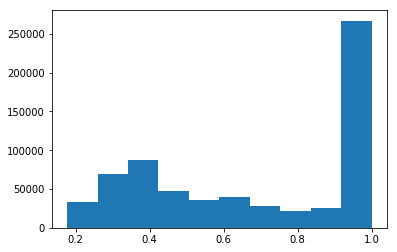

In [30]:
plt.hist(data["moisture availability_8 cm_"])

In [3]:
input_cols_q = ['global horizontal irradiance_0 m_W m-2', 'zenith_0 m_degrees',
              'potential temperature_20 m_K', "potential temperature_10 m_K",
              "potential temperature_2 m_K", 'temperature change_15 m_K m-1', 'temperature change_30 m_K m-1',
              'pressure_2 m_hPa', 'wind speed_20 m_m s-1', 'wind speed_10 m_m s-1', 'bulk richardson_10-2 m_',
               'mixing ratio_2 m_g kg-1','mixing ratio_10 m_g kg-1', 'mixing ratio_20 m_g kg-1',
               'mixing ratio change_15 m_g kg-1 m-1', 'mixing ratio change_30 m_g kg-1 m-1',
               'soil water content_3 cm_m3 m-3']
output_col_q = 'moisture scale_surface_g kg-1'

In [5]:
output_extremes = data[output_col].quantile([0.001, 0.999])
print(output_extremes.iloc[0])
data_qc = data.loc[(data[output_col] >= output_extremes.iloc[0]) & (data[output_col] <= output_extremes.iloc[1])]

-0.9482798372886521


In [6]:
split_date = pd.Timestamp("2011-01-01")
train_data = data_qc.loc[:split_date]
test_data = data_qc.loc[split_date:]

In [118]:
data['temperature change_15 m_K m-1'].min()

-0.3420800000000043

In [7]:
scaler = StandardScaler()
scaled_train_in = scaler.fit_transform(train_data[input_cols])
scaled_test_in = scaler.transform(test_data[input_cols])
scaler_q = StandardScaler()
scaled_train_in_q = scaler_q.fit_transform(train_data[input_cols_q])
scaled_test_in_q = scaler_q.transform(test_data[input_cols_q])

In [11]:
def create_nn_model(input_size=len(input_cols), hidden_neurons=40, activation="elu", loss="mae"):
    nn_in = Input((input_size, ))
    nn_h1 = Dense(hidden_neurons, activation=activation)(nn_in)
    #nn_d1 = Dropout(0.2)(nn_h1)
    nn_h2 = Dense(hidden_neurons, activation=activation)(nn_h1)
    #nn_d2 = Dropout(0.2)(nn_h2)
    nn_out = Dense(1)(nn_h2)
    nn_model = Model(nn_in, nn_out)
    nn_model.compile(loss=loss, optimizer=Adam(lr=0.0001))
    return nn_model
nn_model_mse = create_nn_model(input_size=len(input_cols), loss="mse")
nn_model_mse_q = create_nn_model(input_size=len(input_cols_q), loss="mse")


In [12]:
nn_model_mse.fit(scaled_train_in, train_data.loc[:, output_col], batch_size=256, epochs=15)
nn_model_mse_q.fit(scaled_train_in_q, train_data.loc[:, output_col_q], batch_size=256, epochs=20)

Epoch 1/15
402191/402191 [==============================] - 2s 5us/step - loss: 0.0211
Epoch 2/15
402191/402191 [==============================] - 2s 5us/step - loss: 0.0039
Epoch 3/15
402191/402191 [==============================] - 2s 5us/step - loss: 0.0033
Epoch 4/15
402191/402191 [==============================] - 2s 5us/step - loss: 0.0030
Epoch 5/15
402191/402191 [==============================] - 2s 5us/step - loss: 0.0029
Epoch 6/15
402191/402191 [==============================] - 2s 4us/step - loss: 0.0028
Epoch 7/15
402191/402191 [==============================] - 2s 4us/step - loss: 0.0028
Epoch 8/15
402191/402191 [==============================] - 2s 4us/step - loss: 0.0027
Epoch 9/15
402191/402191 [==============================] - 2s 5us/step - loss: 0.0027
Epoch 10/15
402191/402191 [==============================] - 2s 5us/step - loss: 0.0027
Epoch 11/15
402191/402191 [==============================] - 2s 5us/step - loss: 0.0027
Epoch 12/15
402191/402191 [==============

In [13]:
nn_preds_mse = nn_model_mse.predict(scaled_test_in).ravel()
nn_preds_mse_q = nn_model_mse_q.predict(scaled_test_in_q).ravel()

In [16]:
rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", n_jobs=4, max_leaf_nodes=1000)
rf.fit(scaled_train_in, train_data[output_col])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=1000,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [18]:
rf_q = RandomForestRegressor(n_estimators=100, max_features="sqrt", n_jobs=4, max_leaf_nodes=1000)
rf_q.fit(scaled_train_in_q, train_data[output_col_q])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=1000,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [20]:
rf_preds = rf.predict(scaled_test_in)
rf_preds_q = rf_q.predict(scaled_test_in_q)

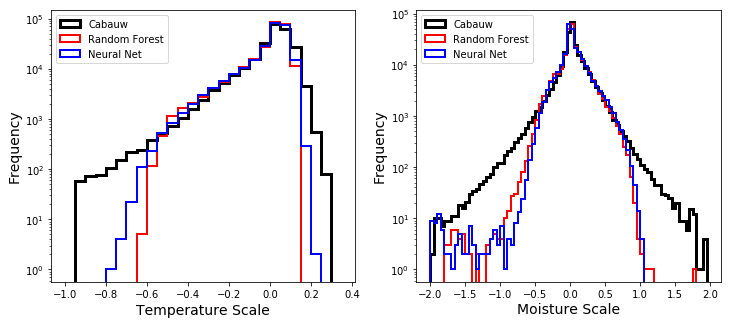

In [42]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
tstar_bins = np.arange(-1, 0.4, 0.05)
plt.hist(test_data[output_col], bins=tstar_bins, histtype="step", lw=3, color='k', label="Cabauw")
plt.gca().set_yscale("log")
plt.hist(rf_preds, bins=tstar_bins, histtype="step", lw=2, color='r', label="Random Forest")
plt.hist(nn_preds_mse, bins=tstar_bins, histtype="step", lw=2, color='b', label="Neural Net")
plt.xlabel("Temperature Scale", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(loc=2)
plt.subplot(1, 2, 2)
qstar_bins = np.arange(-2, 2, 0.05)
plt.hist(test_data[output_col_q], bins=qstar_bins, histtype="step", lw=3, color='k', label="Cabauw")
plt.gca().set_yscale("log")
plt.hist(rf_preds_q, bins=qstar_bins, histtype="step", lw=2, color='r', label="Random Forest")
plt.hist(nn_preds_mse_q, bins=qstar_bins, histtype="step", lw=2, color='b', label="Neural Net")
plt.xlabel("Moisture Scale", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(loc=2)
plt.savefig("scale_dists.png", dpi=200, bbox_inches="tight")

In [50]:
print("MAE")
print("T*")
print("RF", mean_absolute_error(test_data[output_col], rf_preds))
print("NN", mean_absolute_error(test_data[output_col], nn_preds_mse))
print("Q*")
print("RF", mean_absolute_error(test_data[output_col_q], rf_preds_q))
print("NN", mean_absolute_error(test_data[output_col_q], nn_preds_mse_q))
print("RMSE")
print("RF", np.sqrt(mean_squared_error(test_data[output_col], rf_preds)))
print("NN", np.sqrt(mean_squared_error(test_data[output_col], nn_preds_mse)))
print("Q*")
print("RF", np.sqrt(mean_squared_error(test_data[output_col_q], rf_preds_q)))
print("NN", np.sqrt(mean_squared_error(test_data[output_col_q], nn_preds_mse_q)))

MAE
T*
RF 0.027288443488206172
NN 0.028596948169136147
Q*
RF 0.05308214898456292
NN 0.05591344879744222
RMSE
RF 0.04357864873775122
NN 0.044733039709190195
Q*
RF 0.11343064977610604
NN 0.11851625779393908


In [54]:
nn_mse_quantiles = np.percentile(nn_preds_mse.ravel(), np.arange(1, 99, 2))
nn_rf_quantiles = np.percentile(rf_preds.ravel(), np.arange(1, 99, 2))
test_quantiles = np.percentile(test_data["temperature scale_surface_K"], np.arange(1, 99, 2))
nn_mse_quantiles_q = np.percentile(nn_preds_mse_q.ravel(), np.arange(1, 99, 2))
nn_rf_quantiles_q = np.percentile(rf_preds_q.ravel(), np.arange(1, 99, 2))
test_quantiles_q = np.percentile(test_data[output_col_q], np.arange(1, 99, 2))

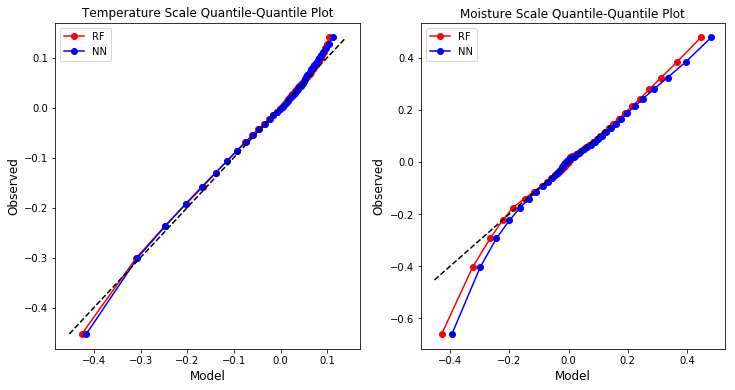

In [58]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(nn_rf_quantiles, test_quantiles, 'ro-', label="RF")
plt.plot(nn_mse_quantiles, test_quantiles, 'bo-', label="NN")
ref_line = np.linspace(test_quantiles.min(), test_quantiles.max(), 10)
plt.plot(ref_line, ref_line, 'k--')
plt.legend()
plt.xlabel("Model", fontsize=12)
plt.ylabel("Observed", fontsize=12)
plt.title("Temperature Scale Quantile-Quantile Plot")
plt.subplot(1, 2,2)
plt.plot(nn_rf_quantiles_q, test_quantiles_q, 'ro-', label="RF")
plt.plot(nn_mse_quantiles_q, test_quantiles_q, 'bo-', label="NN")
ref_line = np.linspace(test_quantiles.min(), test_quantiles.max(), 10)
plt.plot(ref_line, ref_line, 'k--')
plt.legend()
plt.xlabel("Model", fontsize=12)
plt.ylabel("Observed", fontsize=12)
plt.title("Moisture Scale Quantile-Quantile Plot")
plt.savefig("scale_qq_plots.png", dpi=200, bbox_inches="tight")

Text(0, 0.5, 'Observed')

/Users/dgagne/miniconda3/envs/ml/lib/python3.6/site-packages/matplotlib/colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


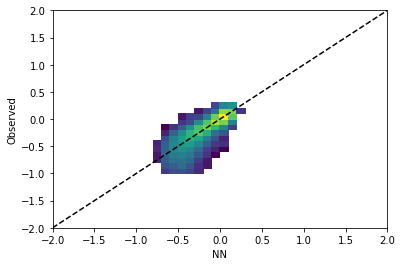

In [276]:
bins = np.arange(-2, 2.1, 0.1)
_ = plt.hist2d(nn_preds_mse, test_data[output_col], norm=LogNorm(), cmin=1, bins=bins)
plt.plot(bins, bins, 'k--')
plt.xlabel("NN")
plt.ylabel("Observed")

In [130]:
mean_squared_error(test_data[output_col], nn_preds_mse)

0.0021000318817935002

In [59]:
def feature_importance(x, y, model, metric_function, x_columns=None, permutations=30, processes=1, seed=8272):
    """
    Calculate permutation feature importance scores for an arbitrary machine learning model.

    Args:
        x: ndarray of dimension (n_examples, n_features) that contains the input data for the ML model.
        y: ndarray of dimension (n_examples, ) that contains the true target values.
        model: machine learning model object in scikit-learn format (contains fit and predict methods).
        metric_function: scoring function with the input format (y_true, y_predicted) to match scikit-learn.
        x_columns (ndarray or None): list or array of column names. If not provided, indices will be used instead.
        permutations (int): Number of times a column is randomly shuffled.
        processes (int): Number of multiprocessor processes used for parallel computation of importances
        seed (int): Random seed.

    Returns:
        pandas DataFrame of dimension (n_columns, permutations) that contains the change in score
        for each column and permutation.
    """
    if x_columns is None:
        x_columns = np.arange(x.shape[1])
    if type(x_columns) == list:
        x_columns = np.array(x_columns)
    predictions = model.predict(x).ravel()
    score = metric_function(y, predictions)
    print(score)
    np.random.seed(seed=seed)
    perm_matrix = np.zeros((x_columns.shape[0], permutations))

    def update_perm_matrix(result):
        perm_matrix[result[0]] = result[1]
    if processes > 1:
        pool = Pool(processes)
        for c in range(len(x_columns)):
            pool.apply_async(feature_importance_column,
                             (x, y, c, permutations, deepcopy(model), metric_function, np.random.randint(0, 100000)),
                              callback=update_perm_matrix)
        pool.close()
        pool.join()
    else:
        for c in range(len(x_columns)):
            result = feature_importance_column(x, y, c, permutations, model,
                                               metric_function, np.random.randint(0, 100000))
            update_perm_matrix(result)
    #diff_matrix = score - perm_matrix
    return pd.DataFrame(perm_matrix, index=x_columns, columns=np.arange(permutations))

def feature_importance_column(x, y, column_index, permutations, model, metric_function, seed):
    """
    Calculate the permutation feature importance score for a single input column. It is the error score on
    a given set of data after the values in one column have been shuffled among the different examples.

    Args:
        x: ndarray of dimension (n_examples, n_features) that contains the input data for the ML model.
        y: ndarray of dimension (n_examples, ) that contains the true target values.
        column_index: Index of the x column being permuted
        permutations: Number of permutations run to calculate importance score distribution
        model: machine learning model object in scikit-learn format (contains fit and predict methods).
        metric_function: scoring function with the input format (y_true, y_predicted) to match scikit-learn.
        seed (int): random seed.

    Returns:
        column_index, permutation, perm_score
    """
    try:
        rs = np.random.RandomState(seed=seed)
        perm_indices = np.arange(x.shape[0])
        perm_scores = np.zeros(permutations)
        x_perm = np.copy(x)
        for p in range(permutations):
            print(column_index, p)
            rs.shuffle(perm_indices)
            x_perm[:, column_index] = x[perm_indices, column_index]
            perm_pred = model.predict(x_perm)
            perm_scores[p] = metric_function(y, perm_pred)
        return column_index, perm_scores
    except Exception as e:
        print(traceback.format_exc())
        raise e

In [60]:
pd.Series(rf.feature_importances_, index=input_cols).sort_values()[::-1]

global horizontal irradiance_0 m_W m-2    0.324049
bulk richardson_10-2 m_                   0.286871
zenith_0 m_degrees                        0.146625
temperature change_15 m_K m-1             0.086373
temperature change_30 m_K m-1             0.052328
wind speed_20 m_m s-1                     0.036095
wind speed_10 m_m s-1                     0.028423
potential temperature_2 m_K               0.014139
potential temperature_20 m_K              0.009538
potential temperature_10 m_K              0.009487
pressure_2 m_hPa                          0.006071
dtype: float64

In [62]:
pd.Series(rf_q.feature_importances_, index=input_cols_q).sort_values()[::-1]

bulk richardson_10-2 m_                   0.225701
global horizontal irradiance_0 m_W m-2    0.194100
zenith_0 m_degrees                        0.174600
temperature change_15 m_K m-1             0.089733
wind speed_10 m_m s-1                     0.052546
wind speed_20 m_m s-1                     0.045609
temperature change_30 m_K m-1             0.042960
potential temperature_2 m_K               0.028778
potential temperature_20 m_K              0.021603
potential temperature_10 m_K              0.020477
pressure_2 m_hPa                          0.016431
soil water content_3 cm_m3 m-3            0.016214
mixing ratio_2 m_g kg-1                   0.015268
mixing ratio change_30 m_g kg-1 m-1       0.015090
mixing ratio_10 m_g kg-1                  0.014284
mixing ratio_20 m_g kg-1                  0.014148
mixing ratio change_15 m_g kg-1 m-1       0.012457
dtype: float64

In [63]:
rf_importances = feature_importance(scaled_train_in, train_data[output_col].values, rf,
                                   mean_squared_error, x_columns=input_cols, permutations=1)

0.001971948984474734
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0


In [70]:
rf_q_importances = feature_importance(scaled_train_in_q, train_data[output_col_q].values, rf_q,
                                   mean_squared_error, x_columns=input_cols_q, permutations=1)

0.009450081167261787
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0


In [67]:
rf_importances.sort_values(by=0)[::-1] / 0.00197

,0
global horizontal irradiance_0 m_W m-2,3.750796
bulk richardson_10-2 m_,2.523768
zenith_0 m_degrees,1.755650
temperature change_15 m_K m-1,1.296468
wind speed_20 m_m s-1,1.271081
wind speed_10 m_m s-1,1.162744
potential temperature_20 m_K,1.111445
temperature change_30 m_K m-1,1.099131
potential temperature_10 m_K,1.089242
potential temperature_2 m_K,1.077997


In [71]:
rf_q_importances.sort_values(by=0)[::-1] / 0.00945

,0
global horizontal irradiance_0 m_W m-2,3.170581
bulk richardson_10-2 m_,2.698820
zenith_0 m_degrees,2.292842
wind speed_10 m_m s-1,1.491433
temperature change_15 m_K m-1,1.413464
wind speed_20 m_m s-1,1.404636
soil water content_3 cm_m3 m-3,1.328409
temperature change_30 m_K m-1,1.257048
potential temperature_10 m_K,1.226940
potential temperature_20 m_K,1.209498


In [72]:
nn_mse_importances = feature_importance(scaled_train_in, train_data[output_col].values, nn_model_mse, 
                                        mean_squared_error, x_columns=input_cols,
                                        permutations=1)

0.0025893420302075245
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0


In [224]:
nn_q_imps = feature_importance(scaled_train_in_q, train_data["moisture scale_surface_g kg-1"].values, 
                               nn_model_mse_q, mean_squared_error, x_columns=input_cols_q,
                              permutations=1)

0.01820952223341036
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0


In [81]:
rf.estimators_[0].tree_.

array([ 0, 10, 10, ...,  0, -2, -2])

In [226]:
nn_q_imps.sort_values(by=0) 

,0
mixing ratio change_15 m_g kg-1 m-1,0.018454
pressure_2 m_hPa,0.018485
soil water content_3 cm_m3 m-3,0.018689
mixing ratio change_30 m_g kg-1 m-1,0.018714
temperature change_30 m_K m-1,0.018736
temperature change_15 m_K m-1,0.020004
zenith_0 m_degrees,0.020173
wind speed_20 m_m s-1,0.021098
potential temperature_20 m_K,0.021214
wind speed_10 m_m s-1,0.024086


In [74]:
nn_mse_importances.sort_values(by=0)[::-1] / 0.002589

,0
potential temperature_2 m_K,50.547737
potential temperature_20 m_K,30.232959
potential temperature_10 m_K,5.036333
global horizontal irradiance_0 m_W m-2,5.035092
wind speed_20 m_m s-1,2.711746
wind speed_10 m_m s-1,2.030932
bulk richardson_10-2 m_,1.498443
temperature change_15 m_K m-1,1.485163
zenith_0 m_degrees,1.342284
temperature change_30 m_K m-1,1.158576


In [184]:
rf_importances.sort_values(by=0) / 0.0019747706937348545

,0
global horizontal irradiance_0 m_W m-2,-2.791841
bulk richardson_10-2 m_,-1.690026
zenith_0 m_degrees,-0.657886
wind speed_20 m_m s-1,-0.317781
temperature change_15 m_K m-1,-0.309917
wind speed_10 m_m s-1,-0.157450
potential temperature_10 m_K,-0.104501
potential temperature_20 m_K,-0.096421
temperature change_30 m_K m-1,-0.089902
potential temperature_2 m_K,-0.077621


In [92]:
num_inputs = 10
pd_inputs = np.zeros((len(input_cols), num_inputs))
pd_vals = np.zeros((len(input_cols), num_inputs))
pd_vals_rf = np.zeros((len(input_cols), num_inputs))
for i, input_col in enumerate(input_cols):
    print(input_col)
    pd_inputs[i] = np.linspace(scaled_train_in[:, i].min(), scaled_train_in[:, i].max(), num_inputs)
    pd_vals[i] = partial_dependence_1d(scaled_train_in, nn_model_mse, i, pd_inputs[i])
    pd_vals_rf[i] = partial_dependence_1d(scaled_train_in, rf, i, pd_inputs[i])

global horizontal irradiance_0 m_W m-2
zenith_0 m_degrees
potential temperature_20 m_K
potential temperature_10 m_K
potential temperature_2 m_K
temperature change_15 m_K m-1
temperature change_30 m_K m-1
pressure_2 m_hPa
wind speed_20 m_m s-1
wind speed_10 m_m s-1
bulk richardson_10-2 m_


In [90]:
pd_inputs = np.zeros((len(input_cols), num_inputs))

for i, input_col in enumerate(input_cols):
    print(input_col)
    pd_inputs[i] = np.linspace(scaled_train_in[:, i].min(), scaled_train_in[:, i].max(), num_inputs)

global horizontal irradiance_0 m_W m-2
zenith_0 m_degrees
potential temperature_20 m_K
potential temperature_10 m_K
potential temperature_2 m_K
temperature change_15 m_K m-1
temperature change_30 m_K m-1
pressure_2 m_hPa
wind speed_20 m_m s-1
wind speed_10 m_m s-1
bulk richardson_10-2 m_


In [228]:
pd_inputs = np.arange(-3, 3.5, 0.5)
pd_vals_q = np.zeros((len(input_cols_q), pd_inputs.size))
for i, input_col in enumerate(input_cols_q):
    print(input_col)
    pd_vals_q[i] = partial_dependence_1d(scaled_train_in_q, nn_model_mse_q, i, pd_inputs)
    

global horizontal irradiance_0 m_W m-2
zenith_0 m_degrees
potential temperature_20 m_K
potential temperature_10 m_K
potential temperature_2 m_K
temperature change_15 m_K m-1
temperature change_30 m_K m-1
pressure_2 m_hPa
wind speed_20 m_m s-1
wind speed_10 m_m s-1
bulk richardson_10-2 m_
mixing ratio_10 m_g kg-1
mixing ratio_20 m_g kg-1
mixing ratio change_15 m_g kg-1 m-1
mixing ratio change_30 m_g kg-1 m-1
soil water content_3 cm_m3 m-3


0
1
2
3
4
5
6
7
8
9
10
11


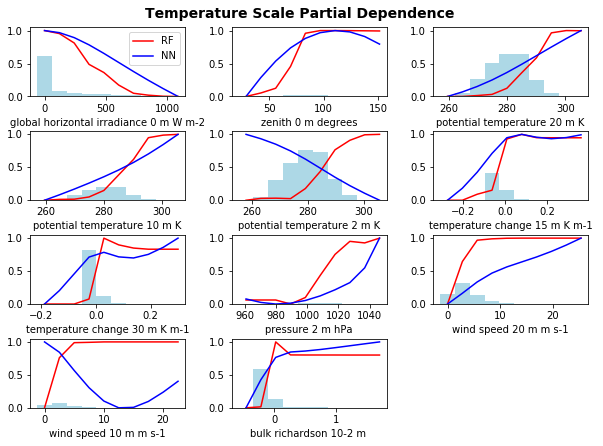

In [100]:
pd_scaled_inputs = scaler.inverse_transform(pd_inputs.T)
fig, axes = plt.subplots(4, 3, figsize=(10, 7))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
for a, ax in enumerate(axes.ravel()):
    print(a)
    if a < len(input_cols):
        ax.plot(pd_scaled_inputs[:, a], (pd_vals_rf[a] - pd_vals_rf[a].min()) / (pd_vals_rf[a].max() - pd_vals_rf[a].min()), 'r-', label="RF")
        ax.plot(pd_scaled_inputs[:, a], (pd_vals[a] - pd_vals[a].min()) / (pd_vals[a].max() - pd_vals[a].min()), 'b-', label='NN')
        ax.set_xlabel(input_cols[a].replace("_", " "))
        in_hist, _ = np.histogram(train_data[input_cols[a]], bins=pd_scaled_inputs[:, a])
        ax.bar(pd_scaled_inputs[:-1, a], 
               height=in_hist / in_hist.sum() * (np.maximum(pd_vals[a].max(), pd_vals_rf[a].max()) - 
                                                 np.minimum(pd_vals[a].min(), pd_vals_rf[a].min())) * 2, 
               width=pd_scaled_inputs[1:, a] - pd_scaled_inputs[:-1, a], bottom=0, 
                                                                                           color='lightblue')
        if a == 0:
            ax.legend()
    else:
        ax.axis("off")
fig.suptitle("Temperature Scale Partial Dependence", fontsize=14, fontweight="bold", y=0.92)
plt.savefig("temperature_scale_pdp_rf_nn.png", dpi=200, bbox_inches="tight")

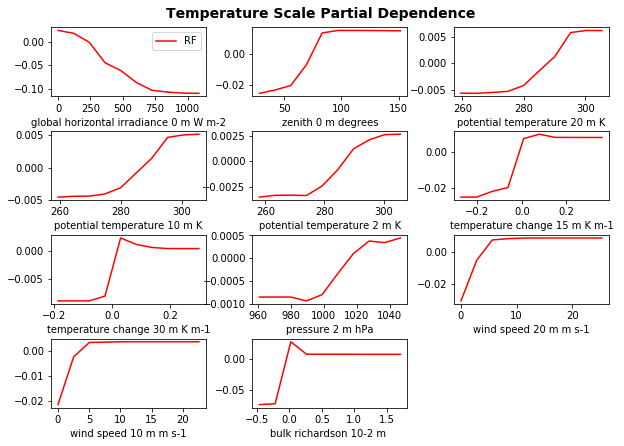

In [96]:
pd_scaled_inputs = scaler.inverse_transform(pd_inputs.T)
fig, axes = plt.subplots(4, 3, figsize=(10, 7))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
for a, ax in enumerate(axes.ravel()):
    if a < len(input_cols):
        #ax.plot(pd_scaled_inputs[:, a], pd_vals[a], 'r-', label='RF')
        ax.plot(pd_scaled_inputs[:, a], pd_vals_rf[a], 'r-', label="RF")

        ax.set_xlabel(input_cols[a].replace("_", " "))
        #in_hist, _ = np.histogram(train_data[input_cols[a]], bins=pd_scaled_inputs[:, a])
        #ax.bar(pd_scaled_inputs[:-1, a], 
        #       height=in_hist / in_hist.sum() * (np.maximum(pd_vals[a].max(), pd_vals_rf[a].max()) - 
        #                                         np.minimum(pd_vals[a].min(), pd_vals_rf[a].min())), 
        #       width=pd_scaled_inputs[1:, a] - pd_scaled_inputs[:-1, a], bottom=np.minimum(pd_vals[a].min(),
        #                                                                                   pd_vals_rf[a].min()), 
        #                                                                                   color='lightblue')
        if a == 0:
            ax.legend()
    else:
        ax.axis("off")
fig.suptitle("Temperature Scale Partial Dependence", fontsize=14, fontweight="bold", y=0.92)
plt.savefig("temperature_scale_pdp_rf.png", dpi=200, bbox_inches="tight")

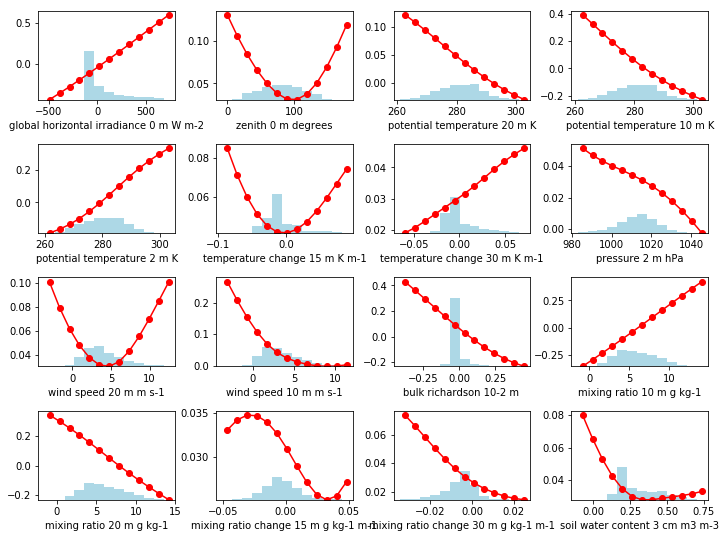

In [238]:
pd_scaled_inputs = scaler_q.inverse_transform(np.tile(pd_inputs.reshape(-1, 1), pd_vals_q.shape[0]))
fig, axes = plt.subplots(4, 4, figsize=(12, 9))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
for a, ax in enumerate(axes.ravel()):
    if a < len(input_cols_q):
        ax.plot(pd_scaled_inputs[:, a], pd_vals_q[a], 'ro-')
        #ax.plot(pd_scaled_inputs[:, a], pd_vals_rf[a], 'bo-')

        ax.set_xlabel(input_cols_q[a].replace("_", " "))
        in_hist, _ = np.histogram(train_data[input_cols_q[a]], bins=pd_scaled_inputs[:, a])
        ax.bar(pd_scaled_inputs[:-1, a], 
               height=in_hist / in_hist.sum() * (pd_vals_q[a].max() - pd_vals_q[a].min()), 
               width=pd_scaled_inputs[1:, a] - pd_scaled_inputs[:-1, a], bottom=pd_vals_q[a].min(), color='lightblue')
    else:
        ax.axis("off")

11

array([[-4.90856204e+02, -1.13123159e-01,  2.62633038e+02,
         2.62485734e+02,  2.61668868e+02, -8.68890416e-02,
        -5.96150343e-02,  9.85344972e+02, -2.94092034e+00,
        -3.08173756e+00, -3.73324027e-01],
       [-3.88600440e+02,  1.48384364e+01,  2.65972607e+02,
         2.65848125e+02,  2.65123086e+02, -7.22323872e-02,
        -4.87292574e-02,  9.90347186e+02, -1.65417012e+00,
        -1.87581591e+00, -3.04822215e-01],
       [-2.86344676e+02,  2.97899959e+01,  2.69312175e+02,
         2.69210515e+02,  2.68577304e+02, -5.75757327e-02,
        -3.78434804e-02,  9.95349400e+02, -3.67419910e-01,
        -6.69894272e-01, -2.36320403e-01],
       [-1.84088912e+02,  4.47415554e+01,  2.72651743e+02,
         2.72572906e+02,  2.72031522e+02, -4.29190783e-02,
        -2.69577035e-02,  1.00035161e+03,  9.19330304e-01,
         5.36027370e-01, -1.67818591e-01],
       [-8.18331480e+01,  5.96931150e+01,  2.75991312e+02,
         2.75935297e+02,  2.75485741e+02, -2.82624239e-02,
  